## Ploting results from feature compression datasets

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

### BLAT Ostermeier 2014

In [ ]:
# Once we have all the fasta files and metadata we can extract the embeddings for each fasta.
python scripts/extract.py esm2_t30_150M_UR50D data/sumo1_human_data.fasta embeddings/sumo1_esm2_150M --repr_layers 30 --include bos mean per_tok


# Then we can compress the embeddings with the following command
dir_path = 'embeddings/BLAT_ECOLX_Ostermeier2014_esm2_150M/'
for i in ['mean', 'bos', 'max_pool', 'pca1', 'pca2', 'pca1-2', 'iDCT', 'rbf1', 'sigmoid1']:
    print(f'Compressing embeddings using {i}')
    embed = load_per_tok_embeds(dir_path, i)
    with open(f'embeddings/BLAT_ECOLX_Ostermeier2014_esm2_150M_compressed/BLAT_ECOLX_Ostermeier2014_esm2_150M_{i}.pkl', 'wb') as f:
        pickle.dump(embed, f)


# or one by one, but will take too long
python scripts/compressing_embeddings_v02.py  -e embeddings/sumo1_esm2_150M -c mean -l 30


# or by using the following command, see the script for more details
bash run_compression.sh


# with the compressed embedding we can run the regression model, see script for more details
python scripts/run_reg_Lasso.py -i embeddings/BLAT_ECOLX_Ostermeier2014_esm2_150M_compressed -m data/BLAT_ECOLX_Ostermeier2014_metadata_v02.csv -o results/BLAT_ECOLX_Ostermeier2014_esm2_150M_layer_30_compressed.csv

In [ ]:
# checking corrupted files
path_compressed_embeds = 'embeddings/PABP_YEAST_Fields2013_doubles_esm2_150M_compressed'
for file in os.listdir(path_compressed_embeds):
    if file.endswith('.pkl'):
        method = file.split('_')[-1].split('.')[0]
        print('\nResults for method:', method)
        file_path = os.path.join(path_compressed_embeds, file)
        embed = pd.read_pickle(file_path)
        embed_df = pd.DataFrame.from_dict(embed, orient='index').reset_index()
        embed_df.rename(columns={'index': 'ID'}, inplace=True)

## Results

In [2]:
def plot_results(res_path):
    results = pd.read_csv(res_path, index_col=0)
    results.sort_values('Compression_methd', inplace=True)
    title = ' '.join(res_path.split('/')[-1].split('_')[:-5])
    plt.figure(figsize=(8, 3))
    sns.barplot(data=results, x='Compression_methd', y='R2_score_test')
    plt.title(title)
    plt.ylim(0, 1)
    plt.ylabel('R2 Score')
    plt.xlabel('Compression methd')
    plt.show()

In [4]:
def plot_results2(res_path):
    results = pd.read_csv(res_path, index_col=0)
    results.sort_values('Compression_methd', inplace=True)
    title = ' '.join(res_path.split('/')[-1].split('_')[:-5])
    plt.figure(figsize=(8, 3))
    sns.barplot(data=results, x='Compression_methd', y='rho_score_test')
    plt.title(title)
    plt.ylim(0, 1)
    plt.ylabel('rho Score')
    plt.xlabel('Compression methd')
    plt.show()

In [ ]:
count=0
base_path = 'results/regression_L1_5e-3'
for file in os.listdir(base_path):
    count+=1
    print(count)
    file_path = os.path.join(base_path, file)

    plot_results(file_path)

In [ ]:
count=0
base_path = 'results/idct2'
for file in os.listdir(base_path):
    count+=1
    print(count)
    file_path = os.path.join(base_path, file)

    plot_results(file_path)

## Merging files

In [65]:
base_path = 'results/regression_L1_1e-3'
data = pd.DataFrame()
for file in os.listdir(base_path):
    file_path = os.path.join(base_path, file)
    df = pd.read_csv(file_path, index_col=0)
    dataset = [file.split('_esm2')[0]] *len(df)

    df.insert(0, 'Dataset', dataset,)
    data = pd.concat([data, df])

data = data.query('Dataset != "HIS7_YEAST_Kondrashov2017"')
data

,Dataset,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_methd
0,HG_FLU_Bloom2016,Lasso,1,0.211701,0.975046,1.152943,0.185751,1.002670,1.185001,0.509491,0.504677,148,pca2
1,HG_FLU_Bloom2016,Lasso,2,0.208522,0.974549,1.152919,0.198153,1.023944,1.198264,0.506992,0.493246,139,pca2
2,HG_FLU_Bloom2016,Lasso,3,0.209259,0.980166,1.158123,0.208379,0.964127,1.138799,0.509579,0.519696,146,pca2
3,HG_FLU_Bloom2016,Lasso,4,0.213262,0.972196,1.150066,0.160123,1.033975,1.218825,0.511800,0.442876,142,pca2
4,HG_FLU_Bloom2016,Lasso,5,0.212964,0.979703,1.157106,0.173533,0.968335,1.145604,0.512723,0.476926,147,pca2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,IF1_ECOLI,Lasso,6,0.695225,0.108231,0.152622,0.637445,0.135809,0.192915,0.721036,0.678805,143,pca2
6,IF1_ECOLI,Lasso,7,0.708841,0.108533,0.153429,0.554788,0.122021,0.170633,0.722581,0.658299,153,pca2
7,IF1_ECOLI,Lasso,8,0.712216,0.108295,0.150932,0.497629,0.133309,0.201428,0.723878,0.717433,146,pca2
8,IF1_ECOLI,Lasso,9,0.702979,0.109426,0.154270,0.618916,0.121259,0.165629,0.733136,0.589967,155,pca2


In [66]:
base_path = 'results/idct2'
data2 = pd.DataFrame()
for file in os.listdir(base_path):
    file_path = os.path.join(base_path, file)
    df = pd.read_csv(file_path, index_col=0)
    dataset = [file.split('_esm2')[0]] *len(df)

    df.insert(0, 'Dataset', dataset)
    data2 = pd.concat([data2, df])

data2

,Dataset,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_methd
0,HG_FLU_Bloom2016,Lasso,1,0.478745,0.766544,0.937535,0.428035,0.817018,0.993172,0.733714,0.694004,655,iDCT2
1,HG_FLU_Bloom2016,Lasso,2,0.479798,0.764883,0.934685,0.417030,0.846039,1.021715,0.734648,0.682750,632,iDCT2
2,HG_FLU_Bloom2016,Lasso,3,0.478444,0.770633,0.940563,0.433872,0.787135,0.963043,0.733723,0.701172,665,iDCT2
3,HG_FLU_Bloom2016,Lasso,4,0.483093,0.762659,0.932210,0.389190,0.856573,1.039409,0.735408,0.667017,646,iDCT2
4,HG_FLU_Bloom2016,Lasso,5,0.483675,0.766442,0.937211,0.389890,0.809256,0.984296,0.735522,0.665451,654,iDCT2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,MK01_HUMAN_Johannessen,Lasso,6,0.355238,0.655141,0.912333,0.176296,0.781482,1.072940,0.660973,0.466669,688,iDCT2
6,MK01_HUMAN_Johannessen,Lasso,7,0.355847,0.661227,0.920608,0.186995,0.713238,0.977323,0.659856,0.489888,699,iDCT2
7,MK01_HUMAN_Johannessen,Lasso,8,0.353371,0.658962,0.912658,0.197237,0.743290,1.068908,0.657492,0.515045,676,iDCT2
8,MK01_HUMAN_Johannessen,Lasso,9,0.351787,0.653789,0.915547,0.181299,0.759798,1.059133,0.658030,0.481549,708,iDCT2


In [67]:
df = pd.concat([data, data2]).reset_index(drop=True)
df

,Dataset,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_methd
0,HG_FLU_Bloom2016,Lasso,1,0.211701,0.975046,1.152943,0.185751,1.002670,1.185001,0.509491,0.504677,148,pca2
1,HG_FLU_Bloom2016,Lasso,2,0.208522,0.974549,1.152919,0.198153,1.023944,1.198264,0.506992,0.493246,139,pca2
2,HG_FLU_Bloom2016,Lasso,3,0.209259,0.980166,1.158123,0.208379,0.964127,1.138799,0.509579,0.519696,146,pca2
3,HG_FLU_Bloom2016,Lasso,4,0.213262,0.972196,1.150066,0.160123,1.033975,1.218825,0.511800,0.442876,142,pca2
4,HG_FLU_Bloom2016,Lasso,5,0.212964,0.979703,1.157106,0.173533,0.968335,1.145604,0.512723,0.476926,147,pca2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,MK01_HUMAN_Johannessen,Lasso,6,0.355238,0.655141,0.912333,0.176296,0.781482,1.072940,0.660973,0.466669,688,iDCT2
4796,MK01_HUMAN_Johannessen,Lasso,7,0.355847,0.661227,0.920608,0.186995,0.713238,0.977323,0.659856,0.489888,699,iDCT2
4797,MK01_HUMAN_Johannessen,Lasso,8,0.353371,0.658962,0.912658,0.197237,0.743290,1.068908,0.657492,0.515045,676,iDCT2
4798,MK01_HUMAN_Johannessen,Lasso,9,0.351787,0.653789,0.915547,0.181299,0.759798,1.059133,0.658030,0.481549,708,iDCT2


In [ ]:
for dt in df['Dataset'].unique():
    df_dt = df.query(f'Dataset == "{dt}"').copy()
    df_dt.sort_values('Compression_methd', inplace=True)
    title = ' '.join(dt.split('_'))
    plt.figure(figsize=(10, 3))
    sns.barplot(data=df_dt, x='Compression_methd', y='R2_score_test')
    plt.title(title)
    plt.ylim(0, 1)
    plt.ylabel('R2 Score')
    plt.xlabel('Compression methd')
    plt.show()
    

In [69]:
#data.to_csv('results/summary_DMS_results_regression_1e-3.csv')
#data.to_csv('results/summary_DMS_results_regression_5e-3.csv')
df.to_csv('results/summary_DMS_results_regression_1e-3_v02.csv')

In [33]:
dict_len = {}
for file in os.listdir('embeddings/'):
    if file.endswith('_150M'):
        l = len(os.listdir(f'embeddings/{file}'))
        dict_len[file] = l
        #print(f'{file} -----> {l}')

df = pd.DataFrame.from_dict(dict_len, orient='index').sort_values(0, ascending=True).reset_index()
df.rename(columns={'index': 'Dataset', 0: 'length'}, inplace=True)
df

,Dataset,length
0,YAP1_HUMAN_Fields2012_singles_esm2_150M,362
1,BRCA1_HUMAN_RING_esm2_150M,660
2,UBE4B_MOUSE_Klevit2013_singles_esm2_150M,899
3,BLAT_ECOLX_Tenaillon2013_esm2_150M,989
4,PABP_YEAST_Fields2013_singles_esm2_150M,1187
5,GAL4_YEAST_Shendure2015_esm2_150M,1195
6,RL401_YEAST_Bolon2013_esm2_150M,1269
7,RL401_YEAST_Fraser2016_esm2_150M,1324
8,RL401_YEAST_Bolon2014_esm2_150M,1435
9,IF1_ECOLI_esm2_150M,1439


In [46]:
count=0
for folder in os.listdir('embeddings/'):
    if folder.endswith('_compressed'):
        for file in os.listdir(f'embeddings/{folder}'):
           if 'iDCT2' in file:            
                count+=1

print(count)

40


## Results

In [6]:
data = pd.read_csv('results/summary_DMS_results_regression_1e-3_v02.csv', index_col=0)

l1 = [ 'iDCT', 'pca1-2']
data = data.query("Compression_methd not in @l1").copy()
data

,Dataset,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_methd
0,HG_FLU_Bloom2016,Lasso,1,0.211701,0.975046,1.152943,0.185751,1.002670,1.185001,0.509491,0.504677,148,pca2
1,HG_FLU_Bloom2016,Lasso,2,0.208522,0.974549,1.152919,0.198153,1.023944,1.198264,0.506992,0.493246,139,pca2
2,HG_FLU_Bloom2016,Lasso,3,0.209259,0.980166,1.158123,0.208379,0.964127,1.138799,0.509579,0.519696,146,pca2
3,HG_FLU_Bloom2016,Lasso,4,0.213262,0.972196,1.150066,0.160123,1.033975,1.218825,0.511800,0.442876,142,pca2
4,HG_FLU_Bloom2016,Lasso,5,0.212964,0.979703,1.157106,0.173533,0.968335,1.145604,0.512723,0.476926,147,pca2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,MK01_HUMAN_Johannessen,Lasso,6,0.355238,0.655141,0.912333,0.176296,0.781482,1.072940,0.660973,0.466669,688,iDCT2
4796,MK01_HUMAN_Johannessen,Lasso,7,0.355847,0.661227,0.920608,0.186995,0.713238,0.977323,0.659856,0.489888,699,iDCT2
4797,MK01_HUMAN_Johannessen,Lasso,8,0.353371,0.658962,0.912658,0.197237,0.743290,1.068908,0.657492,0.515045,676,iDCT2
4798,MK01_HUMAN_Johannessen,Lasso,9,0.351787,0.653789,0.915547,0.181299,0.759798,1.059133,0.658030,0.481549,708,iDCT2


In [7]:
cols = ['Dataset', 'R2_score_test', 'rho_score_test', 'nun_zero_coefs']
dataset_order = data[cols].groupby('Dataset').mean().sort_values('rho_score_test', ascending=False).index
data['Dataset'] = pd.Categorical(data['Dataset'], categories=dataset_order, ordered=True)
data.sort_values('Dataset', inplace=True)
data

,Dataset,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_methd
479,PABP_YEAST_Fields2013_doubles,Lasso,10,6.312933e-01,0.189169,0.238089,0.628551,0.188431,0.235669,0.828631,0.821527,146,maxPool
529,PABP_YEAST_Fields2013_doubles,Lasso,10,5.921336e-01,0.199608,0.250414,0.584717,0.199911,0.249186,0.802102,0.791046,122,rbf1
528,PABP_YEAST_Fields2013_doubles,Lasso,9,5.908265e-01,0.199695,0.250410,0.598496,0.199154,0.248654,0.801069,0.805510,123,rbf1
527,PABP_YEAST_Fields2013_doubles,Lasso,8,5.923986e-01,0.199505,0.250149,0.585803,0.199849,0.250463,0.801240,0.802664,120,rbf1
526,PABP_YEAST_Fields2013_doubles,Lasso,7,5.914084e-01,0.199814,0.250527,0.592822,0.197768,0.247750,0.801271,0.800164,121,rbf1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,POLG_HCVJF_Sun2014,Lasso,7,3.179113e-03,0.350592,0.403105,0.003720,0.340894,0.393403,0.051596,0.043184,5,pca2
315,POLG_HCVJF_Sun2014,Lasso,6,3.532637e-03,0.352965,0.404467,-0.027454,0.333245,0.381029,0.071726,-0.027868,2,pca2
314,POLG_HCVJF_Sun2014,Lasso,5,4.605758e-03,0.348006,0.402193,-0.005609,0.356550,0.401150,0.074798,-0.039871,3,pca2
222,POLG_HCVJF_Sun2014,Lasso,3,6.976823e-03,0.347143,0.399372,-0.001074,0.360043,0.420804,0.062709,-0.019862,11,pca1


In [8]:
del_data = ['POLG_HCVJF_Sun2014', 'BRCA1_HUMAN_BRCT','UBE4B_MOUSE_Klevit2013_singles']
data['Dataset'] = data['Dataset'].astype('object')
data_plot = data[~data['Dataset'].isin(del_data)].copy()
data_plot

,Dataset,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_methd
479,PABP_YEAST_Fields2013_doubles,Lasso,10,0.631293,0.189169,0.238089,0.628551,0.188431,0.235669,0.828631,0.821527,146,maxPool
529,PABP_YEAST_Fields2013_doubles,Lasso,10,0.592134,0.199608,0.250414,0.584717,0.199911,0.249186,0.802102,0.791046,122,rbf1
528,PABP_YEAST_Fields2013_doubles,Lasso,9,0.590827,0.199695,0.250410,0.598496,0.199154,0.248654,0.801069,0.805510,123,rbf1
527,PABP_YEAST_Fields2013_doubles,Lasso,8,0.592399,0.199505,0.250149,0.585803,0.199849,0.250463,0.801240,0.802664,120,rbf1
526,PABP_YEAST_Fields2013_doubles,Lasso,7,0.591408,0.199814,0.250527,0.592822,0.197768,0.247750,0.801271,0.800164,121,rbf1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,CALM1_HUMAN_Roth2017,Lasso,4,0.264532,0.235876,0.303687,0.043707,0.285867,0.375443,0.488420,0.247820,170,maxPool
820,CALM1_HUMAN_Roth2017,Lasso,1,0.195614,0.250256,0.321220,0.061117,0.265632,0.339460,0.422231,0.251132,126,mean
818,CALM1_HUMAN_Roth2017,Lasso,9,0.246735,0.245042,0.311591,0.170108,0.238354,0.311951,0.481654,0.348144,178,sigmoid2
819,CALM1_HUMAN_Roth2017,Lasso,10,0.250865,0.241806,0.309079,0.081197,0.265002,0.344329,0.486776,0.303512,173,sigmoid2


In [9]:
old_names = ['HG_FLU_Bloom2016', 'BLAT_ECOLX_Ostermeier2014',
       'RL401_YEAST_Bolon2014', 'PABP_YEAST_Fields2013_doubles',
       'B3VI55_LIPST_Whitehead2015', 'TIM_THETH', 'CALM1_HUMAN_Roth2017',
       'parEparD_Laub2015_all', 'BF520_env_Bloom2018',
       'UBC9_HUMAN_Roth2017', 'DLG4_RAT_Ranganathan2012',
       'BRCA1_HUMAN_RING', 'TPMT_HUMAN_Fowler2018',
       'MTH3_HAEAESTABILIZED_Tawfik2015', 'HSP82_YEAST_Bolon2016',
       'MK01_HUMAN_Johannessen', 'PTEN_HUMAN_Fowler2018',
       'BG505_env_Bloom2018', 'BLAT_ECOLX_Tenaillon2013', 'TIM_SULSO',
       'B3VI55_LIPSTSTABLE', 'RL401_YEAST_Bolon2013',
       'PABP_YEAST_Fields2013_singles', 'BLAT_ECOLX_Ranganathan2015',
       'RL401_YEAST_Fraser2016', 'TIM_THEMA', 'AMIE_PSEAE_Whitehead',
       'BG_STRSQ_hmmerbit', 'GAL4_YEAST_Shendure2015',
       'BLAT_ECOLX_Palzkill2012', 'SUMO1_HUMAN_Roth2017',
       'RASH_HUMAN_Kuriyan', 'YAP1_HUMAN_Fields2012_singles',
       'KKA2_KLEPN_Mikkelsen2014', 'TPK1_HUMAN_Roth2017',
       'PA_FLU_Sun2015', 'IF1_ECOLI']

new_names = ['HG FLU', 'BLAT ECOLX 2014', 'RL401 2014',
       'PABP doubles', 'B3VI55 LIPST',
       'TIM THETH', 'CALM1 HUMAN', 'parEparD all',
       'BF520 env', 'UBC9 HUMAN', 'DLG4 RAT',
       'BRCA1 RING', 'TPMT HUMAN',
       'MTH3 HAEAESTABILIZED', 'HSP82 YEAST',
       'MK01 HUMAN', 'PTEN HUMAN',
       'BG505 env', 'BLAT ECOLX 2013', 'TIM SULSO',
       'B3VI55 LIPSTSTABLE', 'RL401 2013',
       'PABP singles', 'BLAT ECOLX 2015',
       'RL401 2016', 'TIM THEMA', 'AMIE PSEAE',
       'BG STRSQ', 'GAL4 YEAST',
       'BLAT ECOLX 2012', 'SUMO1 HUMAN',
       'RASH HUMAN', 'YAP1 singles',
       'KKA2 KLEPN', 'TPK1 HUMAN',
       'PA FLU', 'IF1 ECOLI']

name_map = dict(zip(old_names, new_names))
name_map

{'HG_FLU_Bloom2016': 'HG FLU',
 'BLAT_ECOLX_Ostermeier2014': 'BLAT ECOLX 2014',
 'RL401_YEAST_Bolon2014': 'RL401 2014',
 'PABP_YEAST_Fields2013_doubles': 'PABP doubles',
 'B3VI55_LIPST_Whitehead2015': 'B3VI55 LIPST',
 'TIM_THETH': 'TIM THETH',
 'CALM1_HUMAN_Roth2017': 'CALM1 HUMAN',
 'parEparD_Laub2015_all': 'parEparD all',
 'BF520_env_Bloom2018': 'BF520 env',
 'UBC9_HUMAN_Roth2017': 'UBC9 HUMAN',
 'DLG4_RAT_Ranganathan2012': 'DLG4 RAT',
 'BRCA1_HUMAN_RING': 'BRCA1 RING',
 'TPMT_HUMAN_Fowler2018': 'TPMT HUMAN',
 'MTH3_HAEAESTABILIZED_Tawfik2015': 'MTH3 HAEAESTABILIZED',
 'HSP82_YEAST_Bolon2016': 'HSP82 YEAST',
 'MK01_HUMAN_Johannessen': 'MK01 HUMAN',
 'PTEN_HUMAN_Fowler2018': 'PTEN HUMAN',
 'BG505_env_Bloom2018': 'BG505 env',
 'BLAT_ECOLX_Tenaillon2013': 'BLAT ECOLX 2013',
 'TIM_SULSO': 'TIM SULSO',
 'B3VI55_LIPSTSTABLE': 'B3VI55 LIPSTSTABLE',
 'RL401_YEAST_Bolon2013': 'RL401 2013',
 'PABP_YEAST_Fields2013_singles': 'PABP singles',
 'BLAT_ECOLX_Ranganathan2015': 'BLAT ECOLX 2015',
 'RL

In [10]:
data_plot['Dataset'] = data_plot['Dataset'].map(name_map)
data_plot.replace('iDCT2', 'iDCT', inplace=True)
data_plot

,Dataset,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_methd
479,PABP doubles,Lasso,10,0.631293,0.189169,0.238089,0.628551,0.188431,0.235669,0.828631,0.821527,146,maxPool
529,PABP doubles,Lasso,10,0.592134,0.199608,0.250414,0.584717,0.199911,0.249186,0.802102,0.791046,122,rbf1
528,PABP doubles,Lasso,9,0.590827,0.199695,0.250410,0.598496,0.199154,0.248654,0.801069,0.805510,123,rbf1
527,PABP doubles,Lasso,8,0.592399,0.199505,0.250149,0.585803,0.199849,0.250463,0.801240,0.802664,120,rbf1
526,PABP doubles,Lasso,7,0.591408,0.199814,0.250527,0.592822,0.197768,0.247750,0.801271,0.800164,121,rbf1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,CALM1 HUMAN,Lasso,4,0.264532,0.235876,0.303687,0.043707,0.285867,0.375443,0.488420,0.247820,170,maxPool
820,CALM1 HUMAN,Lasso,1,0.195614,0.250256,0.321220,0.061117,0.265632,0.339460,0.422231,0.251132,126,mean
818,CALM1 HUMAN,Lasso,9,0.246735,0.245042,0.311591,0.170108,0.238354,0.311951,0.481654,0.348144,178,sigmoid2
819,CALM1 HUMAN,Lasso,10,0.250865,0.241806,0.309079,0.081197,0.265002,0.344329,0.486776,0.303512,173,sigmoid2


In [11]:
dta = data_plot.drop('Model', axis=1).groupby(['Dataset', 'Compression_methd']).mean()
dta.reset_index(inplace=True)
dta.reset_index(inplace=True, drop=True)
dta

,Dataset,Compression_methd,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs
0,AMIE PSEAE,bos,5.5,0.223505,0.264636,0.334178,0.205185,0.267630,0.337704,0.493429,0.475600,57.9
1,AMIE PSEAE,iDCT,5.5,0.464497,0.212590,0.277517,0.403208,0.223169,0.292659,0.731663,0.687478,246.6
2,AMIE PSEAE,maxPool,5.5,0.380658,0.231302,0.298452,0.340511,0.237712,0.307668,0.650134,0.622094,140.2
3,AMIE PSEAE,mean,5.5,0.320527,0.239761,0.312605,0.291992,0.244672,0.318741,0.578010,0.553673,90.7
4,AMIE PSEAE,pca1,5.5,0.349872,0.239549,0.305779,0.307889,0.246401,0.315135,0.623296,0.589364,144.2
...,...,...,...,...,...,...,...,...,...,...,...,...
365,parEparD all,pca2,5.5,0.592681,0.047857,0.089921,0.582222,0.048262,0.090524,0.470023,0.467937,56.5
366,parEparD all,rbf1,5.5,0.646680,0.043030,0.083747,0.633425,0.043527,0.084737,0.458012,0.455400,78.7
367,parEparD all,rbf2,5.5,0.504987,0.051695,0.099129,0.496193,0.051956,0.099501,0.459301,0.458865,39.8
368,parEparD all,sigmoid1,5.5,0.646152,0.043094,0.083809,0.632742,0.043606,0.084811,0.459335,0.456679,77.4


In [12]:
dta2 = dta.groupby(['Dataset', 'Compression_methd']).mean()
dta2[['rho_score_test']].pivot_table(index='Dataset', columns='Compression_methd', values='rho_score_test')

dta_wide = dta2[['rho_score_test']].pivot_table(index='Dataset', columns='Compression_methd', values='rho_score_test')

print('Min improvement:', np.min(abs(dta_wide['iDCT'] - dta_wide['mean'])))
print('Max improvement:', np.max(abs(dta_wide['iDCT'] - dta_wide['mean'])))
print('Average improvement:', np.mean(abs(dta_wide['iDCT'] - dta_wide['mean'])))

Min improvement: 0.0040772529530032076
Max improvement: 0.22679027371179145
Average improvement: 0.058057353667581774


In [13]:
divmod(3, 2)

(1, 1)

In [14]:
# compression_methods = data_plot['Compression_methd'].unique()

# fig, axes = plt.subplots(5, 2, figsize=(10, 50))
# for i, method in enumerate(compression_methods):
#     row, col = divmod(i, 2) # divmod return the quotient and the remainder of a,b
#     filter_data = data_plot.query('Compression_methd == @method')
#     sns.boxplot(data=filter_data, y='Dataset', x='rho_score_test', ax=axes[row, col])
#     axes[row, col].set_title(method)
#     axes[row, col].set_xlabel('rho Score')
#     if col ==1:
#         axes[row, col].set_ylabel('')
#         axes[row, col].set_yticks([])
    
# plt.show()

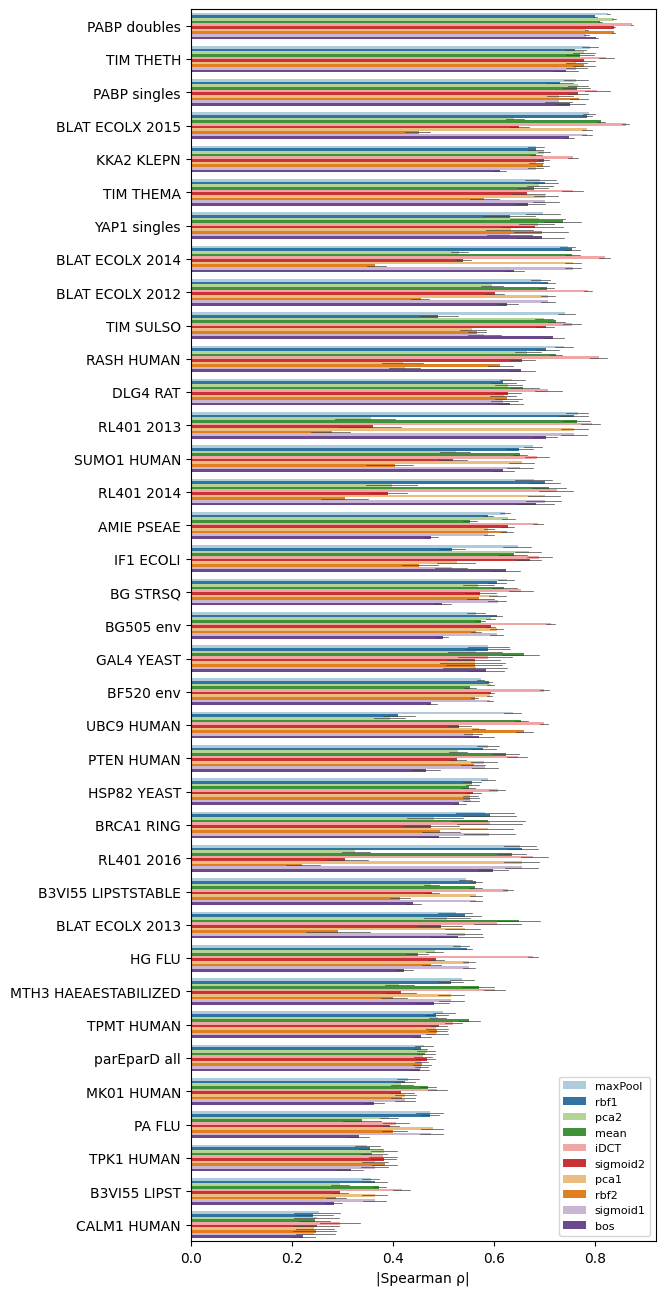

In [15]:
plt.figure(figsize=(6, 16))
sns.barplot(data=data_plot, y='Dataset', x='rho_score_test', hue='Compression_methd', palette='Paired')
plt.ylabel('rho_score_test')
plt.ylabel('')
plt.legend(loc='lower right', prop={'size': 8})
plt.xlabel('|Spearman ρ|')
# Accessing and modifying the error bars
for line in plt.gca().findobj(plt.Line2D):  # Find all Line2D objects, which include the error bars
    line.set_linewidth(0.5) 
plt.savefig('results/summary_DMS_results_all_spearman.png', dpi=600, bbox_inches='tight')
plt.show()

In [16]:
stop

NameError: name 'stop' is not defined

## Results on Pisces dataset

In [ ]:
data = pd.read_csv('results/Pisces_summary_esm2_150M_all_targets.csv').drop(columns='Unnamed: 0')
#l1 = ['mean', 'iDCT']
#data = data.query("Compression_methd in @l1").copy()

del_cols1 = ['W freq', 'M freq','V freq', 'Y freq', 'D freq','C freq', 'F freq']
data = data[~data['Dataset'].isin(del_cols1)].copy()


cols = ['Dataset', 'R2_score_test', 'rho_score_test', 'nun_zero_coefs']
dataset_order = data[cols].groupby('Dataset').mean().sort_values('R2_score_test', ascending=False).index
data['Dataset'] = pd.Categorical(data['Dataset'], categories=dataset_order, ordered=True)
data.sort_values('Dataset', inplace=True)
data

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_methd,Dataset
0,Lasso,1,3.041818e-01,0.125908,0.172892,2.470264e-01,0.126358,0.176141,0.564158,0.504328,199,sigmoid1,SS H
80,Lasso,1,2.705482e-01,0.131004,0.177021,2.210086e-01,0.130741,0.179158,0.555898,0.497916,162,pca1,SS H
79,Lasso,10,2.122037e-02,0.156752,0.204091,2.520994e-02,0.160500,0.209037,0.137342,0.180223,45,rbf2,SS H
78,Lasso,9,2.417840e-02,0.156987,0.204402,1.183367e-02,0.157428,0.204895,0.145753,0.093925,39,rbf2,SS H
77,Lasso,8,2.322735e-02,0.157041,0.204680,1.980443e-02,0.156939,0.202465,0.147760,0.118510,41,rbf2,SS H
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,Lasso,2,1.726756e-01,0.013665,0.017816,1.734611e-01,0.013519,0.017621,0.572540,0.585537,10,mean,P freq
2010,Lasso,1,1.720235e-01,0.013652,0.017763,1.620616e-01,0.013808,0.018281,0.570008,0.553015,9,mean,P freq
2009,Lasso,10,-1.376677e-14,0.015114,0.019618,-5.290295e-06,0.014897,0.019096,NaN,NaN,0,pca2,P freq
2020,Lasso,1,-3.086420e-14,0.015085,0.019521,-8.050061e-07,0.015161,0.019971,NaN,NaN,0,rbf1,P freq


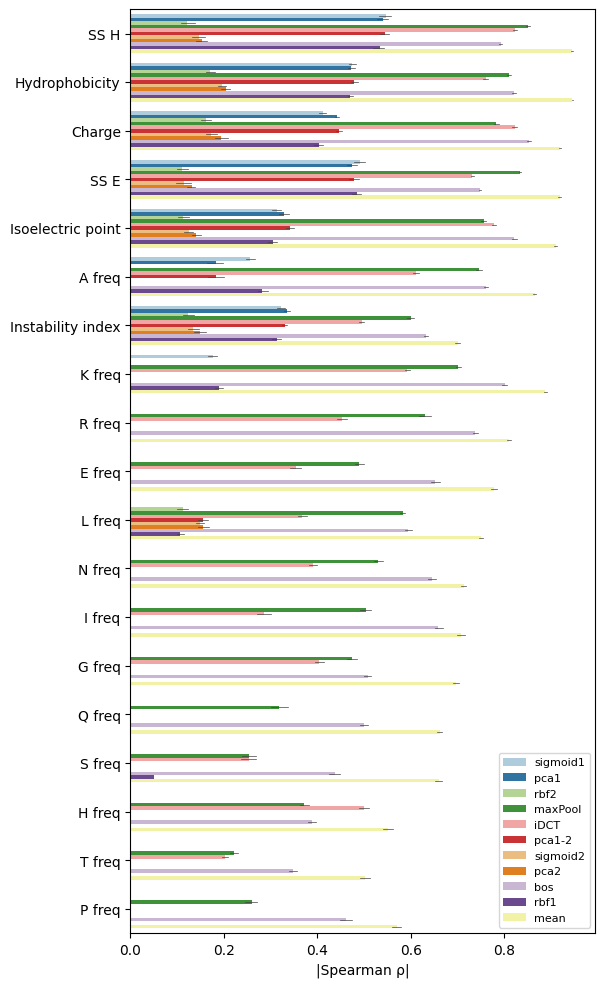

In [ ]:
plt.figure(figsize=(6, 12))
sns.barplot(data=data, y='Dataset', x='rho_score_test', hue='Compression_methd', palette='Paired')
plt.ylabel('rho_score_test')
plt.ylabel('')
plt.legend(loc='lower right', prop={'size': 8})
plt.xlabel('|Spearman ρ|')
# Accessing and modifying the error bars
for line in plt.gca().findobj(plt.Line2D):  # Find all Line2D objects, which include the error bars
    line.set_linewidth(0.5) 
plt.savefig('results/Pisces_summary_esm2_150M_all_targets_spearman.png', dpi=600, bbox_inches='tight')
plt.show()

## Results on Enzyme Classification

In [17]:
data = pd.read_csv('results/uniprot_EC1_esm2_150M_layer_30_compressed.csv')
# l1 = ['mean', 'iDCT']
data = data.query("Compression_methd != 'iDCT'").copy()
data.replace('iDCT2', 'iDCT', inplace=True)

cols = ['Compression_methd', 'Accuracy_test']
dataset_order = data[cols].groupby('Compression_methd').mean().sort_values('Accuracy_test', ascending=False).index
data['Compression_methd'] = pd.Categorical(data['Compression_methd'], categories=dataset_order, ordered=True)
data.sort_values('Compression_methd', inplace=True)
data

,Unnamed: 0,Model,Fold,Accuracy_train,Recall_train,Precision_train,F1_score_train,Accuracy_test,Recall_test,Precision_test,...,class_1_non_zero_coef,class_2_non_zero_coef,class_3_non_zero_coef,class_4_non_zero_coef,class_0_accuracy,class_1_accuracy,class_2_accuracy,class_3_accuracy,class_4_accuracy,Compression_methd
70,0,LogR,1,0.936680,0.893281,0.939415,0.913347,0.876404,0.788529,0.857117,...,273,250,355,237,0.797872,0.512821,0.705882,0.955307,0.970760,mean
72,2,LogR,3,0.935430,0.892644,0.934810,0.911040,0.868914,0.790485,0.827649,...,272,263,353,236,0.841584,0.459459,0.787234,0.899441,0.964706,mean
73,3,LogR,4,0.934805,0.891733,0.934249,0.910709,0.850187,0.750818,0.823232,...,271,273,348,230,0.823529,0.404762,0.647059,0.931373,0.947368,mean
74,4,LogR,5,0.934180,0.890052,0.934521,0.909394,0.889513,0.816223,0.844386,...,287,265,360,237,0.812500,0.650000,0.714286,0.948357,0.955975,mean
75,5,LogR,6,0.935860,0.894761,0.937149,0.913498,0.909944,0.834414,0.862330,...,272,271,367,229,0.917647,0.620690,0.727273,0.928934,0.977528,mean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,7,LogR,8,0.666389,0.542282,0.712563,0.582353,0.497186,0.359466,0.409604,...,394,433,518,517,0.306122,0.066667,0.080000,0.650273,0.694268,rbf2
48,8,LogR,9,0.655144,0.537115,0.700275,0.576291,0.553471,0.377696,0.430720,...,399,440,533,496,0.259740,0.114286,0.105263,0.659193,0.750000,rbf2
49,9,LogR,10,0.655560,0.532941,0.695438,0.571905,0.560976,0.401818,0.415538,...,398,448,528,508,0.385542,0.000000,0.212766,0.710784,0.700000,rbf2
41,1,LogR,2,0.654239,0.534250,0.698518,0.574902,0.528090,0.385502,0.473723,...,395,450,519,505,0.300971,0.108108,0.130435,0.657459,0.730539,rbf2


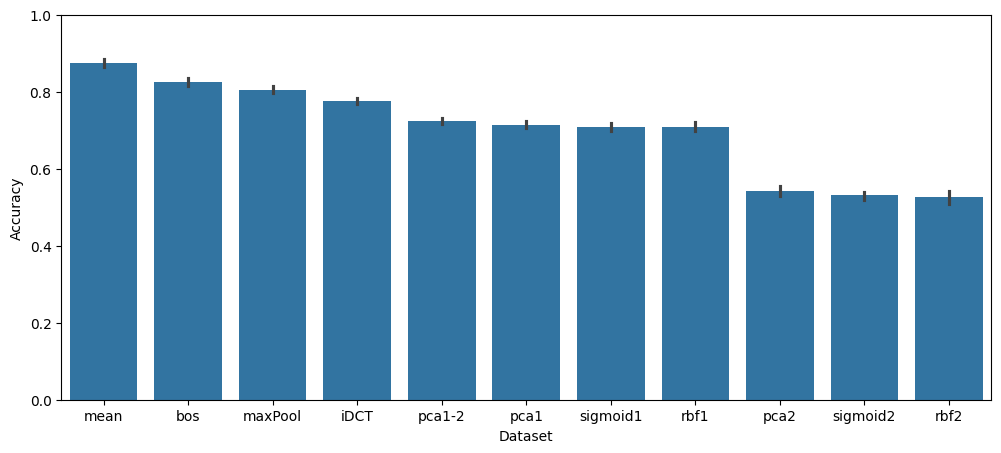

In [19]:
plt.figure(figsize=(12, 5))
#sns.barplot(data=data, x='Compression_methd', y='Accuracy_test', palette='Paired')
sns.barplot(data=data, x='Compression_methd', y='Accuracy_test')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xlabel('Dataset')
plt.savefig('results/uniprot_EC1_esm2_150M_layer_30_compressed.png', dpi=600, bbox_inches='tight')
plt.show()

## Results esm2 150M x 15B

## Pca on mean vs iDCT DMS data

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

metadata = pd.read_csv('data/metadata/BLAT_ECOLX_Ranganathan2015_metadata.csv', index_col=0)

metadata['target'] = scaler.fit_transform(metadata[['target']])
metadata.head()

,ID,mutant,target,sequence
0,BLAT_Ran_H24C,H24C,0.811164,MSIQHFRVALIPFFAAFCLPVFACPETLVKVKDAEDQLGARVGYIE...
1,BLAT_Ran_H24E,H24E,0.845132,MSIQHFRVALIPFFAAFCLPVFAEPETLVKVKDAEDQLGARVGYIE...
2,BLAT_Ran_H24D,H24D,0.868898,MSIQHFRVALIPFFAAFCLPVFADPETLVKVKDAEDQLGARVGYIE...
3,BLAT_Ran_H24G,H24G,0.898506,MSIQHFRVALIPFFAAFCLPVFAGPETLVKVKDAEDQLGARVGYIE...
4,BLAT_Ran_H24F,H24F,0.713526,MSIQHFRVALIPFFAAFCLPVFAFPETLVKVKDAEDQLGARVGYIE...


In [ ]:
embed = pd.DataFrame(pd.read_pickle('embeddings/BLAT_ECOLX_Ranganathan2015_esm2_150M_compressed/embed_layer_30_iDCT2.pkl')).T
embed.reset_index(inplace=True)
embed.rename(columns={'index': 'ID'}, inplace=True)

data = metadata.merge(embed, on='ID')

features = data.iloc[:, metadata.shape[1]:]
target = data['target']

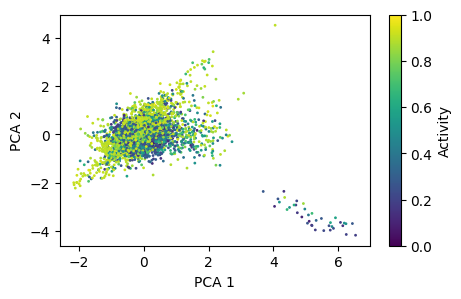

In [ ]:
n_components = 2
pca = PCA(n_components=n_components)
PCAs = pca.fit_transform(scaler.fit_transform(scaler.fit_transform(features)))

plt.figure(figsize=(5, 3))
plt.scatter(PCAs[:, 0], PCAs[:, 1], c=target, cmap='viridis', s=1)
cbar = plt.colorbar()
cbar.set_label('Activity')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
#plt.savefig('results/pca_plots/PCA_BLAT_ECOLX_Ranganathan2015_esm2_150M_layer_30_iDCT2.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
embed = pd.DataFrame(pd.read_pickle('embeddings/BLAT_ECOLX_Ranganathan2015_esm2_150M_compressed/embed_layer_30_mean.pkl')).T
embed.reset_index(inplace=True)
embed.rename(columns={'index': 'ID'}, inplace=True)


data = metadata.merge(embed, on='ID')

features = data.iloc[:, metadata.shape[1]:]
target = data['target']

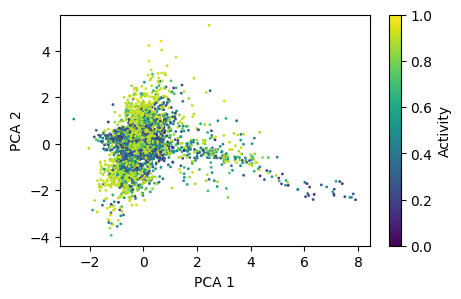

In [ ]:
n_components = 2
pca = PCA(n_components=n_components)
PCAs = pca.fit_transform(scaler.fit_transform(scaler.fit_transform(features)))

plt.figure(figsize=(5, 3))
plt.scatter(PCAs[:, 0], PCAs[:, 1], c=target, cmap='viridis', s=1)
cbar = plt.colorbar()
cbar.set_label('Activity')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
#plt.savefig('results/pca_plots/PCA_BLAT_ECOLX_Ranganathan2015_esm2_150M_layer_30_mean.png', dpi=600, bbox_inches='tight')
plt.show()

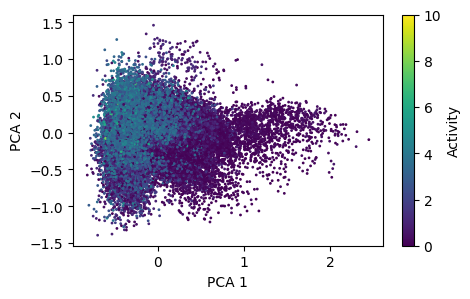

In [ ]:
metadata = pd.read_csv('data/metadata/PABP_YEAST_Fields2013_doubles_metadata.csv', index_col=0)

metadata['target_scaled'] = scaler.fit_transform(metadata[['target']])


embed = pd.DataFrame(pd.read_pickle('embeddings/PABP_YEAST_Fields2013_doubles_esm2_150M_compressed/embed_layer_30_iDCT2.pkl')).T
embed.reset_index(inplace=True)
embed.rename(columns={'index': 'ID'}, inplace=True)


data = metadata.merge(embed, on='ID')

features = data.iloc[:, metadata.shape[1]:]
target = data['target_scaled']


n_components = 2
pca = PCA(n_components=n_components)
PCAs = pca.fit_transform(features)

plt.figure(figsize=(5, 3))
plt.scatter(PCAs[:, 0], PCAs[:, 1], c=target, cmap='viridis', s=1)
cbar = plt.colorbar()
cbar.set_label('Activity')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
#plt.savefig('results/pca_plots/PCA_BLAT_ECOLX_Ranganathan2015_esm2_150M_layer_30_mean.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

metadata = pd.read_csv('data/metadata/PABP_YEAST_Fields2013_doubles_metadata.csv', index_col=0)
metadata['target_scaled'] = scaler.fit_transform(metadata[['target']])


embed = pd.DataFrame(scaler.fit_transform(pd.DataFrame(pd.read_pickle('embeddings/PABP_YEAST_Fields2013_doubles_esm2_150M_compressed/embed_layer_30_mean.pkl')).T))

#embed.reset_index(inplace=True)
#embed.rename(columns={'index': 'ID'}, inplace=True)
embed

,0,1,2,3,4,5,6,7,8,9,...,630,631,632,633,634,635,636,637,638,639
0,0.536133,0.303224,0.305087,0.759835,0.658241,0.571868,0.520438,0.402893,0.324533,0.445307,...,0.527647,0.280264,0.547758,0.532105,0.621793,0.465672,0.420934,0.579559,0.411276,0.604758
1,0.429588,0.432925,0.475785,0.744834,0.525674,0.505510,0.448344,0.590713,0.375673,0.475149,...,0.205009,0.268204,0.516503,0.484480,0.387312,0.494628,0.282435,0.457652,0.646395,0.610696
2,0.606629,0.465876,0.517521,0.728987,0.568019,0.473854,0.417063,0.293259,0.466315,0.617105,...,0.547399,0.318716,0.650444,0.631548,0.485102,0.305510,0.447685,0.267749,0.494668,0.623327
3,0.644400,0.366333,0.535581,0.497351,0.536336,0.499185,0.359933,0.529699,0.260776,0.467837,...,0.476492,0.244949,0.614782,0.467727,0.559120,0.314914,0.515059,0.753502,0.328003,0.369411
4,0.599118,0.515641,0.389519,0.627288,0.454386,0.568957,0.660115,0.519653,0.291705,0.503707,...,0.476448,0.335192,0.550653,0.463683,0.495192,0.459742,0.479489,0.642783,0.497553,0.609694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36516,0.344339,0.723350,0.314177,0.380703,0.298731,0.328732,0.635943,0.618307,0.516993,0.305017,...,0.422173,0.215047,0.653923,0.531936,0.416896,0.404643,0.748711,0.307040,0.396323,0.674981
36517,0.751187,0.199274,0.420698,0.617355,0.653856,0.489469,0.569668,0.482873,0.419750,0.811668,...,0.684222,0.342483,0.623474,0.468041,0.583137,0.442639,0.357968,0.590765,0.352064,0.454443
36518,0.596223,0.468659,0.506252,0.542055,0.699310,0.619824,0.460488,0.386449,0.545769,0.399426,...,0.505072,0.364334,0.660860,0.624291,0.484577,0.364201,0.570365,0.694158,0.443144,0.737231
36519,0.551019,0.432188,0.314122,0.793198,0.609253,0.595193,0.782865,0.611428,0.438355,0.519492,...,0.531171,0.304243,0.462641,0.569493,0.484765,0.411564,0.423031,0.582065,0.346885,0.664729


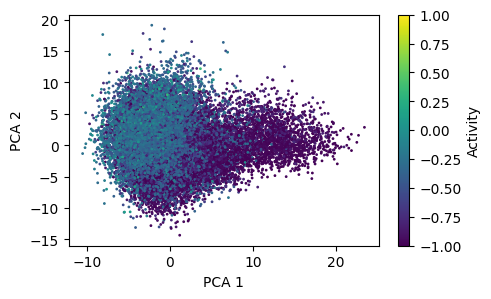

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))

metadata = pd.read_csv('data/metadata/PABP_YEAST_Fields2013_doubles_metadata.csv', index_col=0)

metadata['target_scaled'] = scaler.fit_transform(metadata[['target']])

embed = pd.DataFrame(pd.read_pickle('embeddings/PABP_YEAST_Fields2013_doubles_esm2_150M_compressed/embed_layer_30_iDCT2.pkl')).T
embed.reset_index(inplace=True)
embed.rename(columns={'index': 'ID'}, inplace=True)


data = metadata.merge(embed, on='ID')

features = data.iloc[:, metadata.shape[1]:]
target = data['target_scaled']


n_components = 2
pca = PCA(n_components=n_components)
PCAs = pca.fit_transform(scaler.fit_transform(features))

plt.figure(figsize=(5, 3))
plt.scatter(PCAs[:, 0], PCAs[:, 1], c=target, cmap='viridis', s=1)
cbar = plt.colorbar()
cbar.set_label('Activity')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
#plt.savefig('results/pca_plots/PCA_BLAT_ECOLX_Ranganathan2015_esm2_150M_layer_30_mean.png', dpi=600, bbox_inches='tight')
plt.show()

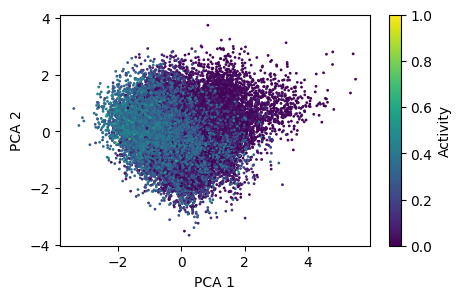

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

metadata = pd.read_csv('data/metadata/PABP_YEAST_Fields2013_doubles_metadata.csv', index_col=0)

metadata['target_scaled'] = scaler.fit_transform(metadata[['target']])

embed = pd.DataFrame(pd.read_pickle('embeddings/PABP_YEAST_Fields2013_doubles_esm2_150M_compressed/embed_layer_30_mean.pkl')).T
embed.reset_index(inplace=True)
embed.rename(columns={'index': 'ID'}, inplace=True)


data = metadata.merge(embed, on='ID')

features = data.iloc[:, metadata.shape[1]:]
target = data['target_scaled']


n_components = 2
pca = PCA(n_components=n_components)
PCAs = pca.fit_transform(scaler.fit_transform(features))

plt.figure(figsize=(5, 3))
plt.scatter(PCAs[:, 0], PCAs[:, 1], c=target, cmap='viridis', s=1)
cbar = plt.colorbar()
cbar.set_label('Activity')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
#plt.savefig('results/pca_plots/PCA_BLAT_ECOLX_Ranganathan2015_esm2_150M_layer_30_mean.png', dpi=600, bbox_inches='tight')
plt.show()

## Pca on mean vs iDCT diverse data

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 10))

metadata = pd.read_csv('data/meta_pisces/pisces_meta_data_PCP_Hydrophobicity.csv')

metadata['target_scaled'] = scaler.fit_transform(metadata[['target']])
metadata.head()

,ID,target,sequence,target_scaled
0,5D8VA,-0.36,AAPANAVTADDPTAIALKYNQDATKSERVAAARPGLPPEEQHCANC...,5.924528
1,3NIRA,0.35,TTCCPSIVARSNFNVCRLPGTPEALCATYTGCIIIPGATCPGDYAN,7.264151
2,5NW3A,-0.52,MAKWVCKICGYIYDEDAGDPDNGISPGTKFEELPDDWVCPICGAPK...,5.622642
3,1UCSA,0.35,NKASVVANQLIPINTALTLIMMKAEVVTPMGIPAEEIPKLVGMQVN...,7.264151
4,3X2MA,-0.24,ATGGYVQQATGQASFTMYSGCGSPACGKAASGFTAAINQLAFGSAP...,6.150943


In [ ]:
embed = pd.DataFrame(pd.read_pickle('embeddings_diverse/pisces_esm2_150M_compressed/embed_layer_30_iDCT2.pkl')).T
embed.reset_index(inplace=True)
embed.rename(columns={'index': 'ID'}, inplace=True)


data = metadata.merge(embed, on='ID')
data.head()

,ID,target,sequence,target_scaled,0,1,2,3,4,5,...,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,5D8VA,-0.36,AAPANAVTADDPTAIALKYNQDATKSERVAAARPGLPPEEQHCANC...,5.924528,-0.140463,0.013632,-0.221426,-0.079810,0.463653,-0.030140,...,-0.117394,-0.076175,-0.423048,0.226204,0.092142,0.081816,-0.196900,0.037491,0.301863,0.081456
1,1UCSA,0.35,NKASVVANQLIPINTALTLIMMKAEVVTPMGIPAEEIPKLVGMQVN...,7.264151,-0.026289,-0.293216,-0.115641,0.307967,0.129225,-0.116829,...,-0.377610,0.191079,-0.119213,-0.052172,-0.009005,-0.003600,0.001283,-0.115802,0.015802,0.054590
2,3X2MA,-0.24,ATGGYVQQATGQASFTMYSGCGSPACGKAASGFTAAINQLAFGSAP...,6.150943,-0.394080,0.237749,0.099991,-0.322717,0.032406,-0.003349,...,-0.499294,0.223793,-0.043933,0.536197,0.126583,-0.216680,-0.303926,0.044346,0.233472,-0.436592
3,2VB1A,-0.47,KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRN...,5.716981,-0.226519,0.140859,-0.430264,0.070477,0.220217,-0.014585,...,-0.369676,0.172321,-0.241742,0.527716,0.084152,0.169467,-0.239939,-0.074930,0.131539,-0.305597
4,1US0A,-0.25,MASRILLNNGAKMPILGLGTWKSPPGQVTEAVKVAIDVGYRHIDCA...,6.132075,-0.313244,0.068968,-0.534783,-0.299709,-0.197263,0.011769,...,-0.349751,0.169313,-0.341667,0.559612,-0.291237,-0.087488,-0.112448,-0.372973,0.181412,-0.430829


In [ ]:
features = data.iloc[:, metadata.shape[1]:]
target = data['target_scaled']

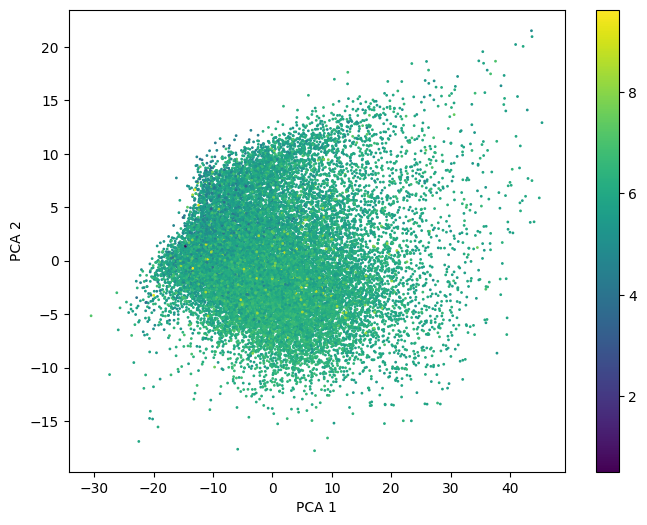

In [ ]:
n_components = 2
pca = PCA(n_components=n_components)
PCAs = pca.fit_transform(features)

plt.figure(figsize=(8, 6))
plt.scatter(PCAs[:, 0], PCAs[:, 1], c=target, cmap='viridis', s=1)
plt.colorbar()
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
#plt.savefig('results/pca_plots/PCA_BLAT_ECOLX_Ranganathan2015_esm2_150M_layer_30_iDCT2.png')
plt.show()

In [ ]:
embed = pd.DataFrame(pd.read_pickle('embeddings_diverse/pisces_esm2_150M_compressed/embed_layer_30_mean2.pkl')).T
embed.reset_index(inplace=True)
embed.rename(columns={'index': 'ID'}, inplace=True)


data = metadata.merge(embed, on='ID')

features = data.iloc[:, metadata.shape[1]:]
target = data['target_scaled']

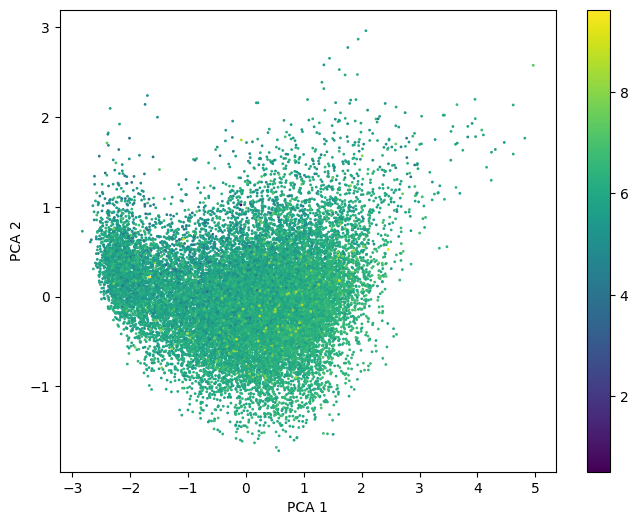

In [ ]:
n_components = 2
pca = PCA(n_components=n_components)
PCAs = pca.fit_transform(features)

plt.figure(figsize=(8, 6))
plt.scatter(PCAs[:, 0], PCAs[:, 1], c=target, cmap='viridis', s=1)
plt.colorbar()
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
#plt.savefig('results/pca_plots/PCA_BLAT_ECOLX_Ranganathan2015_esm2_150M_layer_30_iDCT2.png')
plt.show()

In [ ]:
res = pd.read_csv('results/summary_DMS_15B.csv', index_col=0)
res

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_methd,Dataset
0,Lasso,1,0.848794,0.352045,0.447067,0.783350,0.422454,0.543479,0.910386,0.871133,861,mean,BLAT_Ran
1,Lasso,2,0.848814,0.352424,0.448037,0.760545,0.439828,0.559893,0.910618,0.872180,854,mean,BLAT_Ran
2,Lasso,3,0.851440,0.350521,0.444617,0.758985,0.441554,0.556303,0.910982,0.873762,856,mean,BLAT_Ran
3,Lasso,4,0.851023,0.350362,0.445274,0.753765,0.432569,0.561841,0.910920,0.871759,851,mean,BLAT_Ran
4,Lasso,5,0.848372,0.351659,0.447539,0.771579,0.435401,0.559210,0.910880,0.874358,857,mean,BLAT_Ran
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,Lasso,6,0.692226,0.119751,0.169190,0.641582,0.134589,0.173531,0.846529,0.805915,371,iDCT,RASH_HUMAN
6,Lasso,7,0.694682,0.120150,0.169027,0.602967,0.129455,0.177035,0.850895,0.753902,367,iDCT,RASH_HUMAN
7,Lasso,8,0.693445,0.118583,0.167837,0.597276,0.148995,0.194974,0.849197,0.760744,377,iDCT,RASH_HUMAN
8,Lasso,9,0.689884,0.120231,0.169719,0.625756,0.138177,0.177074,0.847419,0.786252,362,iDCT,RASH_HUMAN


<Axes: xlabel='R2_score_test', ylabel='Dataset'>

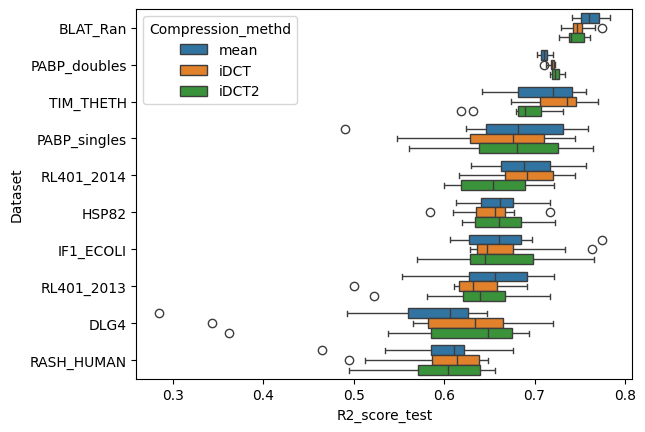

In [ ]:
sns.boxplot(data=res, y='Dataset', x='R2_score_test', hue='Compression_methd')